In [1]:
from genobs.lib import *

In [2]:
h = H_atom_field_D1(-1, E_0_plus(10)) + H_atom(0, "D1")
h

Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = True
Qobj data =
[[-2.68397359e+10  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -3.01490604e+06  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -3.01490604e+06  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.68397359e+10  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.01490604e+06  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -5.22197044e+06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.68397359e+10  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.38498141e+06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.61038415e+10
   0.00000000e+00  0.00000000e+00  0.00000000

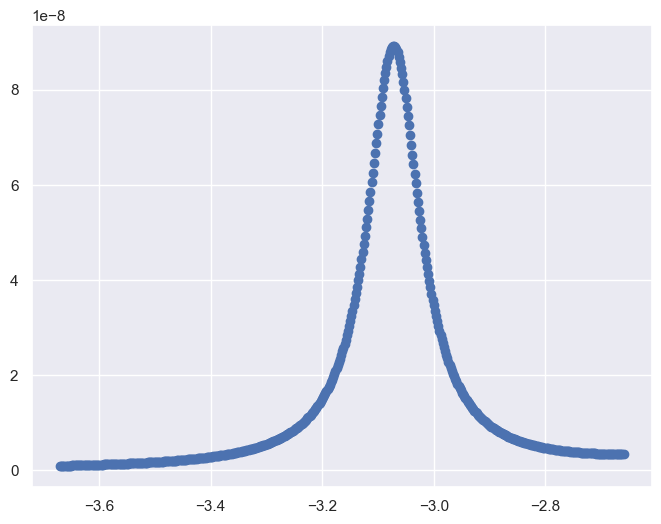

In [3]:
decays = natural_decay_ops_D1() + quenching_ops("D1", gamma=QUENCHING_RATE) + wall_coll("D1")
freqs = np.linspace(-3.67, -2.66, 500)
last_ss = 0
rho_ss_list = []
for freq in freqs:
    if last_ss==0:
        ss = steadystate(H_atom_field_D1(-1, E_0_plus(0.01)) + H_atom(freq*2e9*pi, "D1"), c_op_list=decays, method='iterative-gmres')
    else:
        ss = steadystate(H_atom_field_D1(-1, E_0_plus(0.01)) + H_atom(freq*2e9*pi, "D1"), c_op_list=decays, method='iterative-gmres', x0=operator_to_vector(last_ss))
    last_ss = ss
    rho_ss_list.append(ss)
excited_pops = [sum(rho.diag()[8:]) for rho in rho_ss_list]
plt.figure()
plt.plot(freqs, excited_pops, "o")

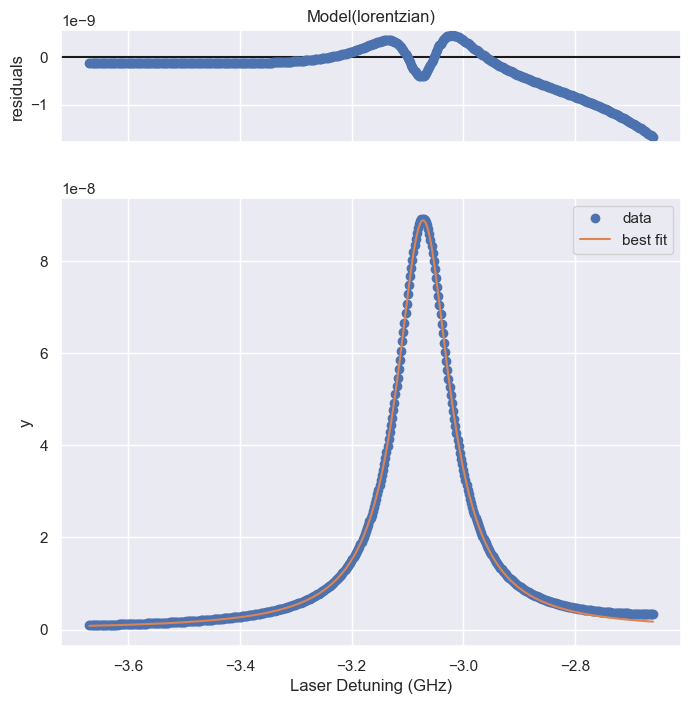

In [4]:
from lmfit.models import LorentzianModel, ConstantModel
mod = LorentzianModel() #+ ConstantModel()
pars = mod.make_params(amplitude=10e-4, sigma=0.013, center=-3.07)
res = mod.fit(data=excited_pops, params=pars, x=freqs)
res.plot();
plt.xlabel("Laser Detuning (GHz)")
res

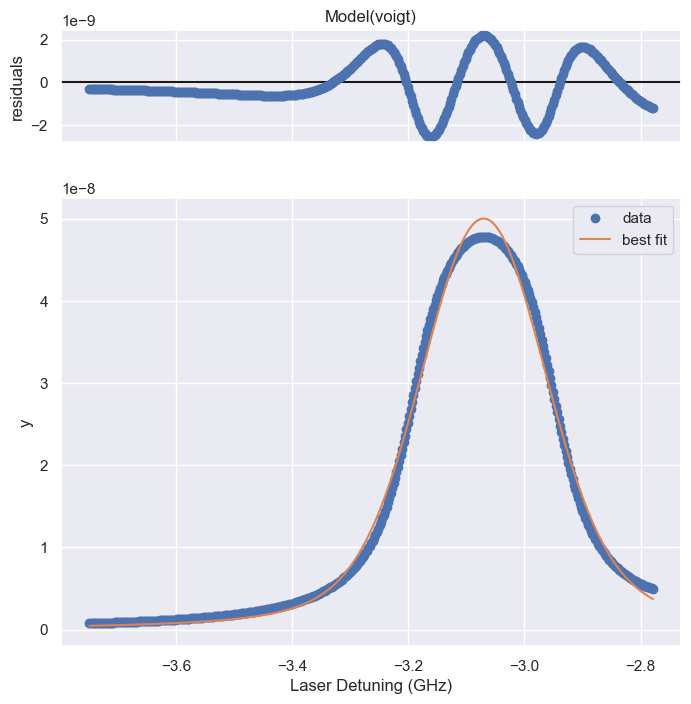

In [5]:
decays = natural_decay_ops_D1() + quenching_ops("D1", gamma=QUENCHING_RATE) + wall_coll("D1")
freqs = np.linspace(-3.87, -2.66, 500)
last_ss = 0
rho_ss_list = []
for freq in freqs:
    if last_ss==0:
        ss = steadystate(H_atom_field_D1(-1, E_0_plus(0.01)) + H_atom(freq*2e9*pi, "D1"), c_op_list=decays)
    else:
        ss = steadystate(
                H_atom_field_D1(-1, E_0_plus(0.01)) + H_atom(freq*2e9*pi, "D1"), 
                c_op_list=decays, 
                method='iterative-gmres', 
                x0=operator_to_vector(last_ss)
            )
    last_ss = ss
    rho_ss_list.append(ss)
excited_pops = [sum(rho.diag()[8:]) for rho in rho_ss_list]
import pandas as pd
ser = pd.Series(excited_pops)
ser.index = freqs
delta = (freqs[-1] - freqs[0]) / len(freqs)
ser = ser.rolling(100, center=True, win_type='gaussian').mean(std=0.500/delta).dropna()

from lmfit.models import VoigtModel
mod = VoigtModel() #+ ConstantModel()
y = ser.dropna()
pars = mod.make_params(amplitude=10e-4, sigma=0.013, center=-3.07)
pars["gamma"].set(vary=True, value=0.013)
res = mod.fit(data=y.to_numpy(), params=pars, x=y.index.to_numpy())
res.plot();
plt.xlabel("Laser Detuning (GHz)")
res